In [381]:
import numpy as np
import pandas as pd
import glob
from zoneinfo import ZoneInfo
from datetime import timezone
import math

In [382]:
TZ_US_LA = ZoneInfo("America/Los_Angeles")
TZ_UTC = timezone.utc

In [383]:
# These are in PST timezone
LAUNCH_DATA_PATHS = [x for x in glob.glob("./data/LaunchMonitor/ags-shots-*")]
APPLE_WATCH_DATA_PATHS = [x for x in glob.glob("./data/SensorLogFiles/*Watch*")]

print(LAUNCH_DATA_PATHS, APPLE_WATCH_DATA_PATHS, sep='\n')

['./data/LaunchMonitor/ags-shots-2023-05-11.csv', './data/LaunchMonitor/ags-shots-2023-04-26.csv', './data/LaunchMonitor/ags-shots-2023-04-17.csv']
['./data/SensorLogFiles/2023-05-11_1_19_58 PM_Apple Watch.csv', './data/SensorLogFiles/2023-04-26_4_18_56 PM_Apple Watch.csv', './data/SensorLogFiles/stream Apple Watch 230423 10_06_54 PM.csv', './data/SensorLogFiles/stream Apple Watch 230426 4_19_13 PM.csv', './data/SensorLogFiles/2023-05-11_1_42_45 PM_Apple Watch.csv']


In [384]:
def load_launch_data(format='AwesomeGolf', tz=TZ_UTC):
    if format != 'AwesomeGolf':
        raise Exception('Not a support format!')

    tdf_list = []
    for file_path in LAUNCH_DATA_PATHS:
        tdf = pd.read_csv(file_path, parse_dates=[0], header=0)
        # Drop the unit row
        tdf = tdf.drop(labels=0, axis=0)
        tdf_list.append(tdf)
    launchdata = pd.concat(tdf_list, axis=0, ignore_index=True)
    launchdata['Date'] = launchdata['Date'].dt.tz_localize(tz)
    launchdata = launchdata.sort_values(by='Date')
    launchdata = launchdata.reset_index()

    return launchdata

In [385]:
launchdata = load_launch_data(tz=TZ_US_LA)
display(launchdata)
print(launchdata.dtypes)

,index,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,146,2023-04-17 14:34:40-07:00,8 Iron,NaN,0.00,72.79,98.63,121.47,149.39,27.93,...,2558,2.85,Actual,NaN,0.39,-0.48,-0.09,NaN,NaN,Straight
1,147,2023-04-17 14:36:42-07:00,8 Iron,NaN,0.00,71.27,65.23,63.77,82.79,19.02,...,1394,3.13,Actual,NaN,0.52,16.54,17.06,NaN,NaN,Push
2,148,2023-04-17 14:37:19-07:00,8 Iron,NaN,0.00,72.92,104.46,160.35,175.56,15.21,...,3788,-22.05,Actual,NaN,2.57,-4.05,-1.49,NaN,NaN,Hook
3,149,2023-04-17 14:38:22-07:00,8 Iron,NaN,0.00,72.61,97.51,138.21,153.74,15.53,...,4569,-3.73,Actual,NaN,1.65,-1.29,0.36,NaN,NaN,Straight
4,150,2023-04-17 14:38:53-07:00,8 Iron,NaN,0.00,74.91,106.86,158.65,173.74,15.09,...,4254,-0.35,Actual,NaN,1.24,-0.23,1.02,NaN,NaN,Straight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,83,2023-05-11 14:12:31-07:00,5 Iron,NaN,0.00,75.21,101.33,142.26,162.61,20.35,...,4345,-7.31,Actual,NaN,-0.69,-0.76,-1.45,NaN,NaN,Draw
160,84,2023-05-11 14:12:43-07:00,5 Iron,NaN,0.00,68.29,96.95,133.49,156.05,22.56,...,3218,17.60,Actual,NaN,-1.56,3.18,1.62,NaN,NaN,Slice
161,85,2023-05-11 14:12:59-07:00,5 Iron,NaN,0.00,74.09,106.57,131.87,161.15,29.29,...,2437,-13.43,Actual,NaN,-0.75,0.24,-0.50,NaN,NaN,Draw
162,86,2023-05-11 14:13:16-07:00,5 Iron,NaN,0.00,72.63,101.60,142.06,165.68,23.61,...,2161,-8.60,Actual,NaN,-0.23,-0.01,-0.24,NaN,NaN,Draw


index                                                   int64
Date                      datetime64[ns, America/Los_Angeles]
Club Type                                              object
Club Description                                      float64
Altitude                                               object
Club Speed                                             object
Ball Speed                                             object
Carry Distance                                         object
Total Distance                                         object
Roll Distance                                          object
Smash                                                 float64
Vertical Launch                                        object
Peak Height                                            object
Descent Angle                                          object
Horizontal Launch                                      object
Carry Lateral Distance                                 object
Total La

In [386]:
print('Launch Data Range: {} to {}'.format(launchdata['Date'].min(), launchdata['Date'].max()))

Launch Data Range: 2023-04-17 14:34:40-07:00 to 2023-05-11 14:13:31-07:00


In [387]:
def load_into_combined_df(paths):
    tdf_list = []
    for file_path in paths:
        tdf_list.append(pd.read_csv(file_path, header=0))
    df = pd.concat(tdf_list, axis=0, ignore_index=True)
    df = df.drop_duplicates(keep='first')
    df = df.reset_index(drop=True)
    return df

In [388]:
# FIXME: For some reason, Pandas complain that there are duplicated indexes if we include the last
# file even when we already drop all duplicates... so will just ignore that file for now.
applewatchdata = load_into_combined_df(APPLE_WATCH_DATA_PATHS[0:4])
applewatchdata = applewatchdata.rename(columns={
    'loggingTime(txt)': 'Date'
})
# The original Date is encoded in UTC-7 (or UTC-8 during PST) format.
applewatchdata['Date'] = pd.to_datetime(applewatchdata['Date']).dt.tz_convert(TZ_US_LA)
# Convert to TimeSeries
applewatchdata = applewatchdata.set_index('Date', drop=True)
applewatchdata = applewatchdata.sort_index()

display(applewatchdata)
print(applewatchdata.dtypes)

,locationTimestamp_since1970(s),locationLatitude(WGS84),locationLongitude(WGS84),locationAltitude(m),locationSpeed(m/s),locationSpeedAccuracy(m/s),locationCourse(°),locationCourseAccuracy(°),locationVerticalAccuracy(m),locationHorizontalAccuracy(m),...,pedometerDistance(m),pedometerFloorAscended(N),pedometerFloorDescended(N),pedometerEndDate(txt),altimeterTimestamp_sinceReboot(s),altimeterReset(bool),altimeterRelativeAltitude(m),altimeterPressure(kPa),batteryState(N),batteryLevel(R)
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-23 22:06:54.330000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.364000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.400000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.431000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.465000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-11 13:37:51.697000-07:00,1.683837e+09,37.423214,-122.181596,45.40375,0.031873,0.023398,73.345652,180.0,2.400000,2.099110,...,28.38083,0.0,0.0,2023-05-11T13:36:53.295-07:00,7.055303e+08,0.0,1.86,101.3255,1.0,0.74
2023-05-11 13:37:51.728000-07:00,1.683837e+09,37.423214,-122.181596,45.40375,0.031873,0.023398,73.345652,180.0,2.400000,2.099110,...,28.38083,0.0,0.0,2023-05-11T13:36:53.295-07:00,7.055303e+08,0.0,1.86,101.3255,1.0,0.74
2023-05-11 13:37:51.763000-07:00,1.683837e+09,37.423214,-122.181596,45.40375,0.031873,0.023398,73.345652,180.0,2.400000,2.099110,...,28.38083,0.0,0.0,2023-05-11T13:36:53.295-07:00,7.055303e+08,0.0,1.86,101.3255,1.0,0.74


locationTimestamp_since1970(s)               float64
locationLatitude(WGS84)                      float64
locationLongitude(WGS84)                     float64
locationAltitude(m)                          float64
locationSpeed(m/s)                           float64
locationSpeedAccuracy(m/s)                   float64
locationCourse(°)                            float64
locationCourseAccuracy(°)                    float64
locationVerticalAccuracy(m)                  float64
locationHorizontalAccuracy(m)                float64
locationFloor(Z)                             float64
accelerometerTimestamp_sinceReboot(s)        float64
accelerometerAccelerationX(G)                float64
accelerometerAccelerationY(G)                float64
accelerometerAccelerationZ(G)                float64
motionTimestamp_sinceReboot(s)               float64
motionYaw(rad)                               float64
motionRoll(rad)                              float64
motionPitch(rad)                             f

In [389]:
print(applewatchdata.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57343 entries, 2023-04-23 22:06:54.330000-07:00 to 2023-05-11 13:37:51.833000-07:00
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   locationTimestamp_since1970(s)             45243 non-null  float64
 1   locationLatitude(WGS84)                    45243 non-null  float64
 2   locationLongitude(WGS84)                   45243 non-null  float64
 3   locationAltitude(m)                        45243 non-null  float64
 4   locationSpeed(m/s)                         45243 non-null  float64
 5   locationSpeedAccuracy(m/s)                 45243 non-null  float64
 6   locationCourse(°)                          45243 non-null  float64
 7   locationCourseAccuracy(°)                  45243 non-null  float64
 8   locationVerticalAccuracy(m)                45243 non-null  float64
 9   locationHorizontalAccuracy(m)    

In [390]:
applewatchdata.head()

,locationTimestamp_since1970(s),locationLatitude(WGS84),locationLongitude(WGS84),locationAltitude(m),locationSpeed(m/s),locationSpeedAccuracy(m/s),locationCourse(°),locationCourseAccuracy(°),locationVerticalAccuracy(m),locationHorizontalAccuracy(m),...,pedometerDistance(m),pedometerFloorAscended(N),pedometerFloorDescended(N),pedometerEndDate(txt),altimeterTimestamp_sinceReboot(s),altimeterReset(bool),altimeterRelativeAltitude(m),altimeterPressure(kPa),batteryState(N),batteryLevel(R)
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-23 22:06:54.330000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.0,-1.0,-1.0,-1.0,68.583588,79.333333,...,0.0,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.364000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.0,-1.0,-1.0,-1.0,68.583588,79.333333,...,0.0,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.400000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.0,-1.0,-1.0,-1.0,68.583588,79.333333,...,0.0,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.431000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.0,-1.0,-1.0,-1.0,68.583588,79.333333,...,0.0,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.465000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.0,-1.0,-1.0,-1.0,68.583588,79.333333,...,0.0,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67


In [391]:
duplicated_data = applewatchdata.duplicated(keep=False)
[i for i, v in duplicated_data.items() if v == True]

[]

In [392]:
print('Apple Data Range: {} to {}'.format(applewatchdata.index.min(), applewatchdata.index.max()))

Apple Data Range: 2023-04-23 22:06:54.330000-07:00 to 2023-05-11 13:37:51.833000-07:00


In [393]:
display(type(launchdata['Date'][0]))
display(type(applewatchdata.index.min()))

pandas._libs.tslibs.timestamps.Timestamp

pandas._libs.tslibs.timestamps.Timestamp

In [394]:
def get_index_of_nearest_datetime(df, dt):
    """
    Parameters
    ----------
    df - a Pandas TimeSeries
    dt - a datetime object
    """
    return df.index.get_indexer([dt], method='nearest')[0]

In [395]:
dt = launchdata['Date'][90]
print(dt)
idt = get_index_of_nearest_datetime(applewatchdata, dt)
print(idt)
item = applewatchdata.iloc[idt]
print(item)
print('='*50)
print(type(item.name))

2023-05-11 13:30:31-07:00
44321
locationTimestamp_since1970(s)                           1683837029.999994
locationLatitude(WGS84)                                          37.423211
locationLongitude(WGS84)                                       -122.181558
locationAltitude(m)                                                44.9145
locationSpeed(m/s)                                                0.130642
locationSpeedAccuracy(m/s)                                        0.027877
locationCourse(°)                                               173.365528
locationCourseAccuracy(°)                                        21.733831
locationVerticalAccuracy(m)                                            2.4
locationHorizontalAccuracy(m)                                     1.799688
locationFloor(Z)                                                   -9999.0
accelerometerTimestamp_sinceReboot(s)                       1005875.532594
accelerometerAccelerationX(G)                                     0.

In [396]:
def is_missing_from_sensor_data(dt, threshold_s=5):
    """
    Pandas will return the index of nearest time.
    In some case, we have missing gap in our sensor dataset.
    We want to make sure that the return data is at least within `threshold_s`
    time delta, otherwise, we consider the data missing.
    """
    idt = get_index_of_nearest_datetime(applewatchdata, dt)
    item = applewatchdata.iloc[idt]
    delta = abs(item.name - dt)
    return delta.total_seconds() > threshold_s

In [397]:
mapped = []
for index, row in launchdata.iterrows():
    dt = row['Date']
    awd_i = get_index_of_nearest_datetime(applewatchdata, dt)
    awd_i_start = awd_i - (12 * 30)
    awd_i_end = awd_i + (1 * 30) # Launch monitor record time after estimated ball stop
    if is_missing_from_sensor_data(dt):
        continue
    mapped.append((row, applewatchdata.iloc[awd_i_start: awd_i_end]))

In [398]:
for launch, awdata in mapped:
    print(launch)
    print("="*50)
    print(awdata)

index                                            88
Date                      2023-04-26 16:20:36-07:00
Club Type                                 Lob Wedge
Club Description                                NaN
Altitude                                       0.00
Club Speed                                    49.93
Ball Speed                                    50.94
Carry Distance                                46.13
Total Distance                                58.11
Roll Distance                                 11.98
Smash                                          1.02
Vertical Launch                               24.55
Peak Height                                   19.26
Descent Angle                                 31.16
Horizontal Launch                              8.45
Carry Lateral Distance                         7.35
Total Lateral Distance                         9.49
Carry Curve Distance                           0.58
Total Curve Distance                           0.97
Attack Angle

In [399]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

def plot_3d_motion(data, start_time=None, end_time=None):
    df = data
    if start_time is not None and end_time is not None:
        # Subset the data between start and end times
        mask = (data.index > start_time) & (data.index <= end_time)
        df = data.loc[mask]

    # Create a new figure and add a 3D subplot.
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D trajectory of motion.
    ax.plot3D(df['motionQuaternionX(R)'], 
              df['motionQuaternionY(R)'], 
              df['motionQuaternionZ(R)'], 'gray')

    # Provide labels
    ax.set_xlabel('Quaternion X')
    ax.set_ylabel('Quaternion Y')
    ax.set_zlabel('Quaternion Z')

    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df['motionYaw(rad)'], df['motionRoll(rad)'], df['motionPitch(rad)'])
    ax.set_xlabel('Yaw (rad)')
    ax.set_ylabel('Roll (rad)')
    ax.set_zlabel('Pitch (rad)')

    plt.show()

# Test the function with start and end times
# dataframe = pd.read_csv('your_file.csv') # Uncomment this if you have your data in a CSV file
# plot_3d_motion(dataframe, '2023-05-11 13:19:58', '2023-05-11 13:20:58') # Update these timestamps according to your data


In [400]:
print(mapped[3][1])

                                  locationTimestamp_since1970(s)   
Date                                                               
2023-04-26 16:21:14.826000-07:00                    1.682551e+09  \
2023-04-26 16:21:14.856000-07:00                    1.682551e+09   
2023-04-26 16:21:14.892000-07:00                    1.682551e+09   
2023-04-26 16:21:14.927000-07:00                    1.682551e+09   
2023-04-26 16:21:14.962000-07:00                    1.682551e+09   
...                                                          ...   
2023-04-26 16:21:27.859000-07:00                    1.682551e+09   
2023-04-26 16:21:27.894000-07:00                    1.682551e+09   
2023-04-26 16:21:27.929000-07:00                    1.682551e+09   
2023-04-26 16:21:27.964000-07:00                    1.682551e+09   
2023-04-26 16:21:27.995000-07:00                    1.682551e+09   

                                  locationLatitude(WGS84)   
Date                                                  

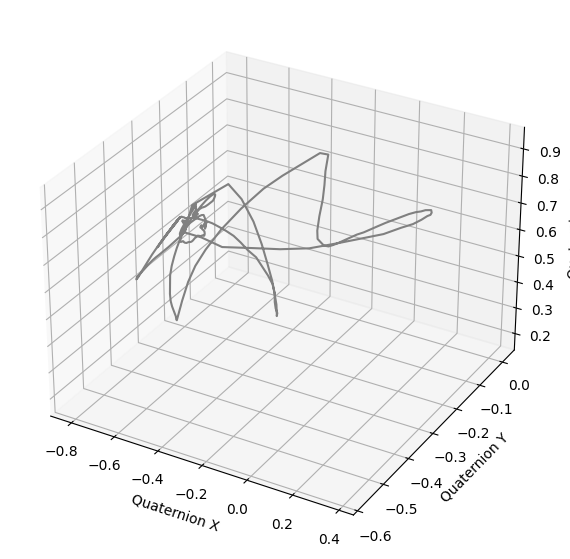

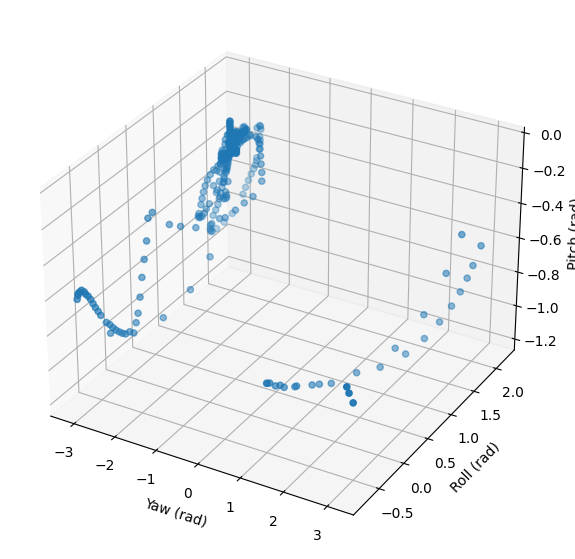

In [401]:
plot_3d_motion(mapped[3][1])

In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_sample(sample):
    launchdata, df = sample
    print(df.index[0])    
    if launchdata is not None:
        print("Total Distance: {}".format(launchdata['Total Distance']))
    fig = plt.figure(figsize=(15,10))
    
    # For user acceleration
    for i, motion in enumerate(['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']):
        ax = fig.add_subplot(3, 3, i+1)
        df[motion].plot(ax=ax)
        ax.set_title(motion)
    
    # For rotation rates
    for i, motion in enumerate(['motionRotationRateX(rad/s)', 'motionRotationRateY(rad/s)', 'motionRotationRateZ(rad/s)']):
        ax = fig.add_subplot(3, 3, i+4)
        df[motion].plot(ax=ax)
        ax.set_title(motion)


        # Additional code for motionRotationRateZ(rad/s) exceeding threshold
        if motion == 'motionRotationRateZ(rad/s)':
            threshold = 5
            mask = df[motion] > threshold
            # TODO: Find better way to estimate peak
            dist_from_mid_index = int(len(df[mask].index)/2)
            for idx in df[mask].index:
                if (dist_from_mid_index > 0):
                    dist_from_mid_index -= 1
                    continue
                ax.axvline(x=idx, color='red', linestyle='--')
                ax.text(idx, 0, idx, color='red')
                break

            if launchdata is not None:
                ax.axvline(x=launchdata['Date'], color='green', linestyle='--')
                ax.text(launchdata['Date'], 0, launchdata['Date'], color='green')

    
    # For yaw, pitch and roll
    for i, motion in enumerate(['motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']):
        ax = fig.add_subplot(3, 3, i+7)
        df[motion].plot(ax=ax)
        ax.set_title(motion)
    
    plt.tight_layout()
    plt.show()


The red line is a strong indication of the "swing" motion while the green line is the time recorded by the launch monitor. Apparently, the recorded time is the time at which the launch monitor estimated that the ball have come to a stop. Naturally, balls that travel further will have a longer gap between the time of the swing (more preciously, the time of impact) and the stop time. Thus, this naive mapping could mislead our machine learning model into relying on where the stop occur... we will likely want to normalize this to the middle.

2023-04-26 16:21:14.826000-07:00
Total Distance: 44.79


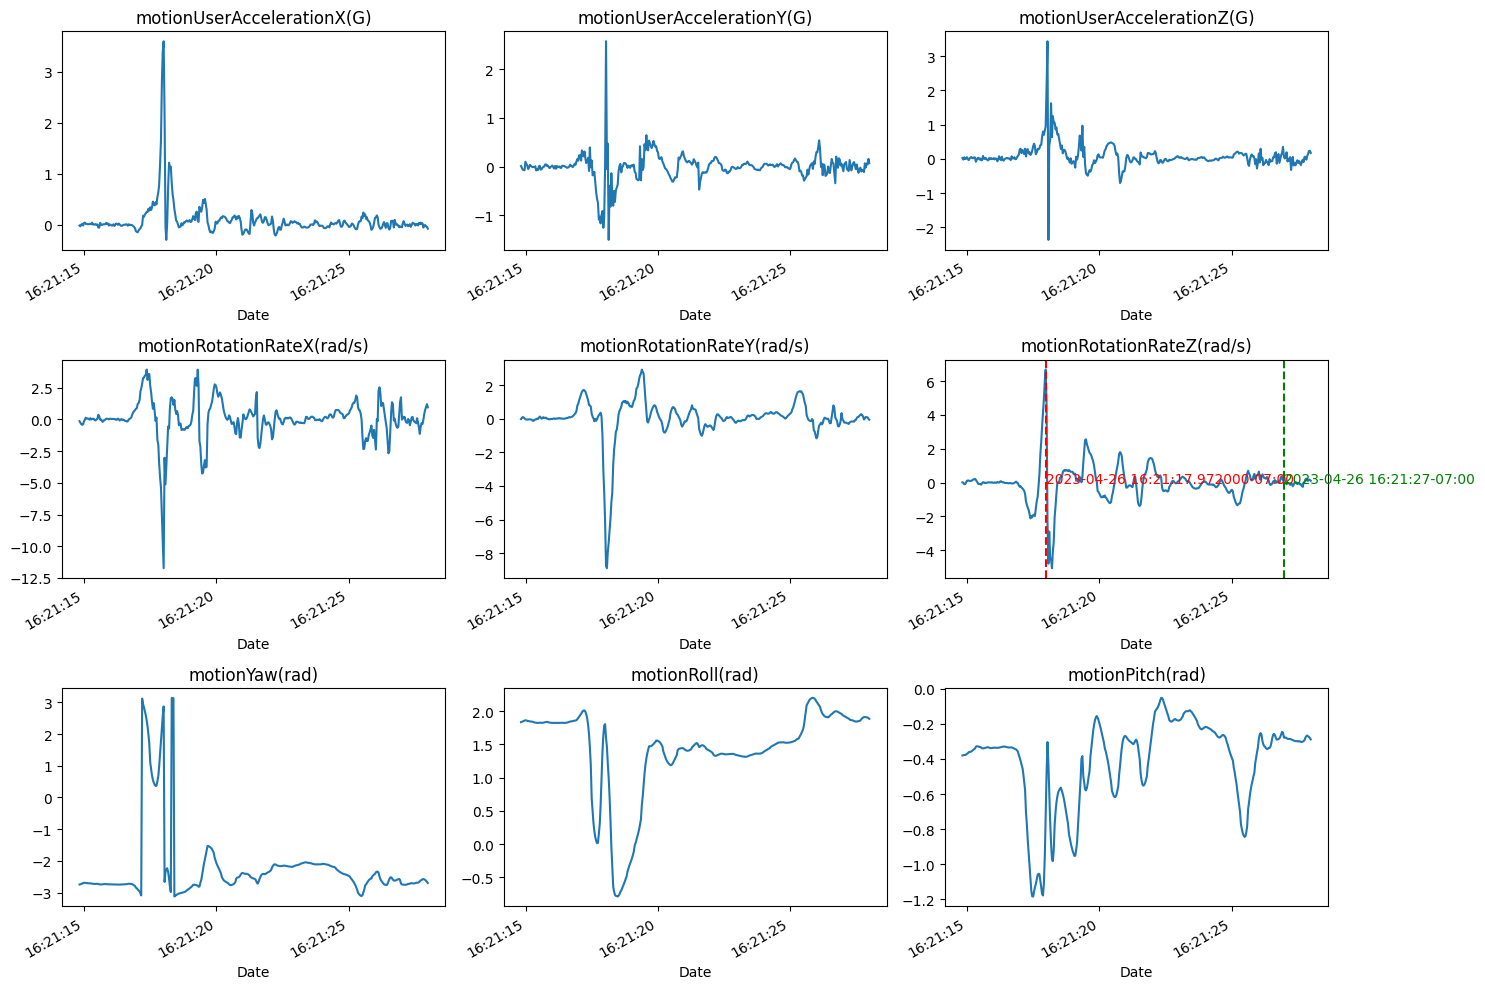

2023-04-26 16:21:30.809000-07:00
Total Distance: 77.62


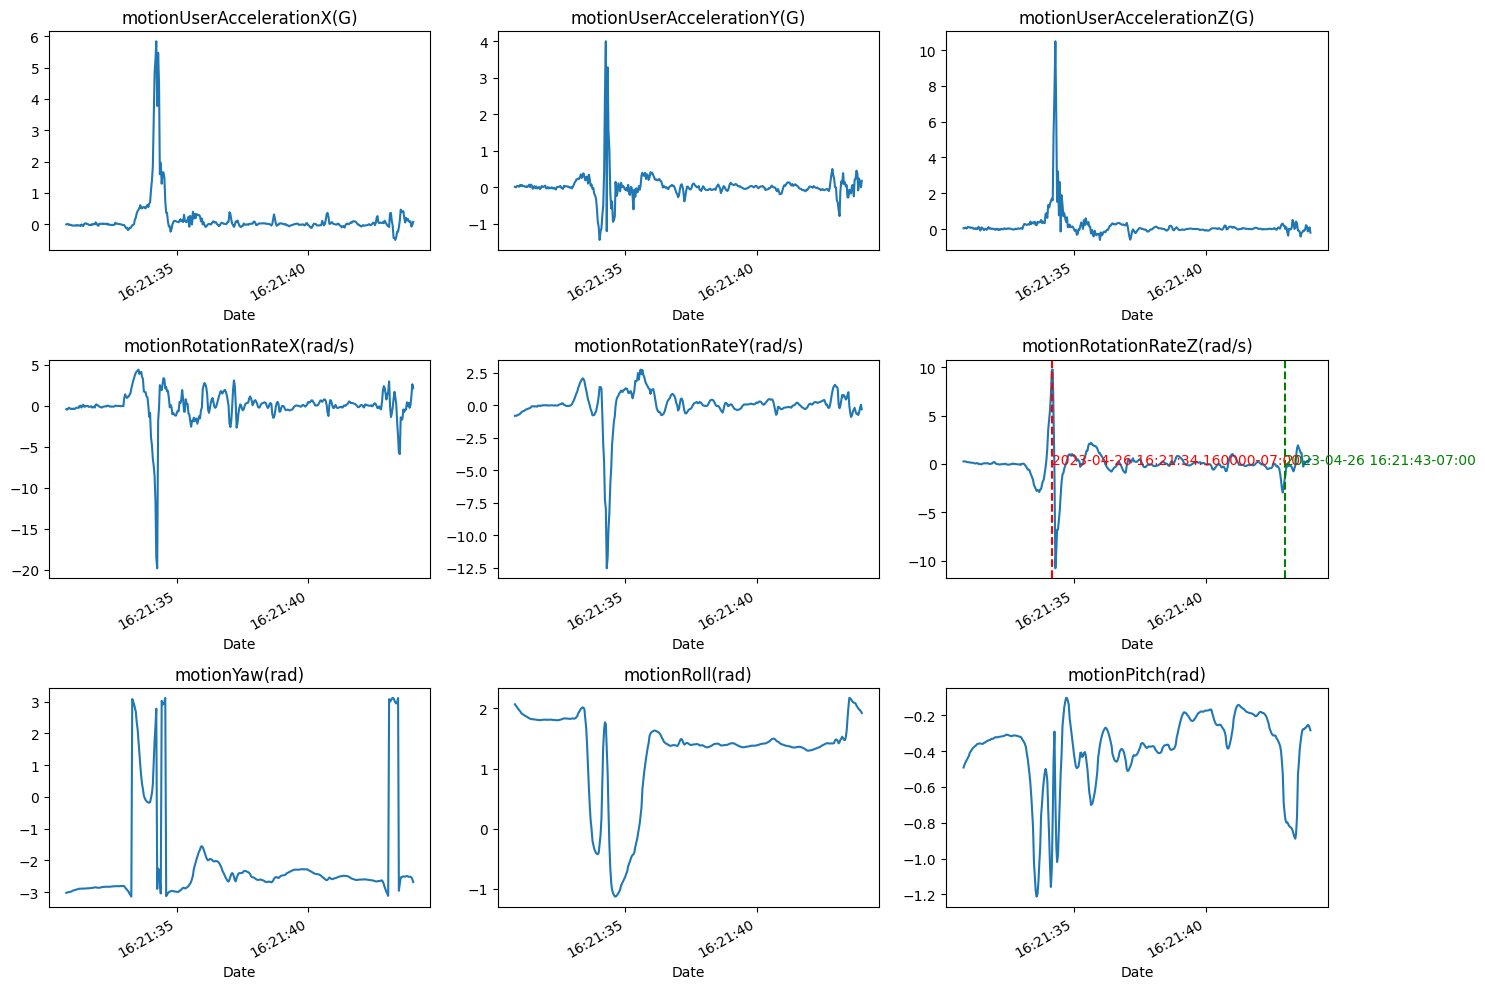

2023-04-26 16:22:05.818000-07:00
Total Distance: 76.66


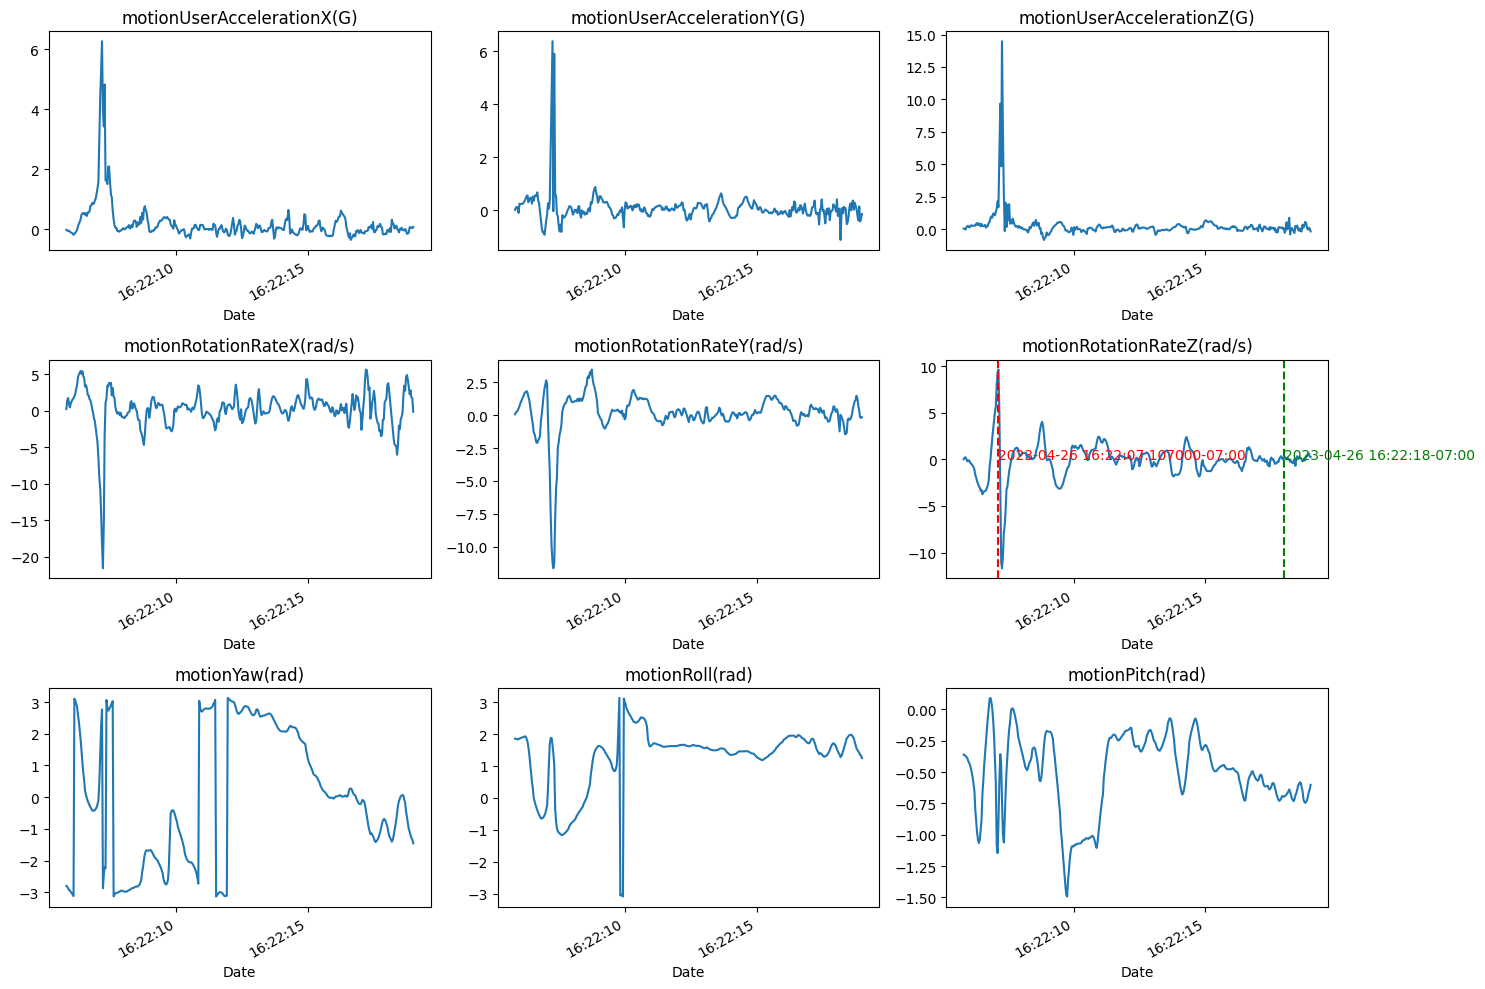

2023-04-26 16:34:19.794000-07:00
Total Distance: 164.86


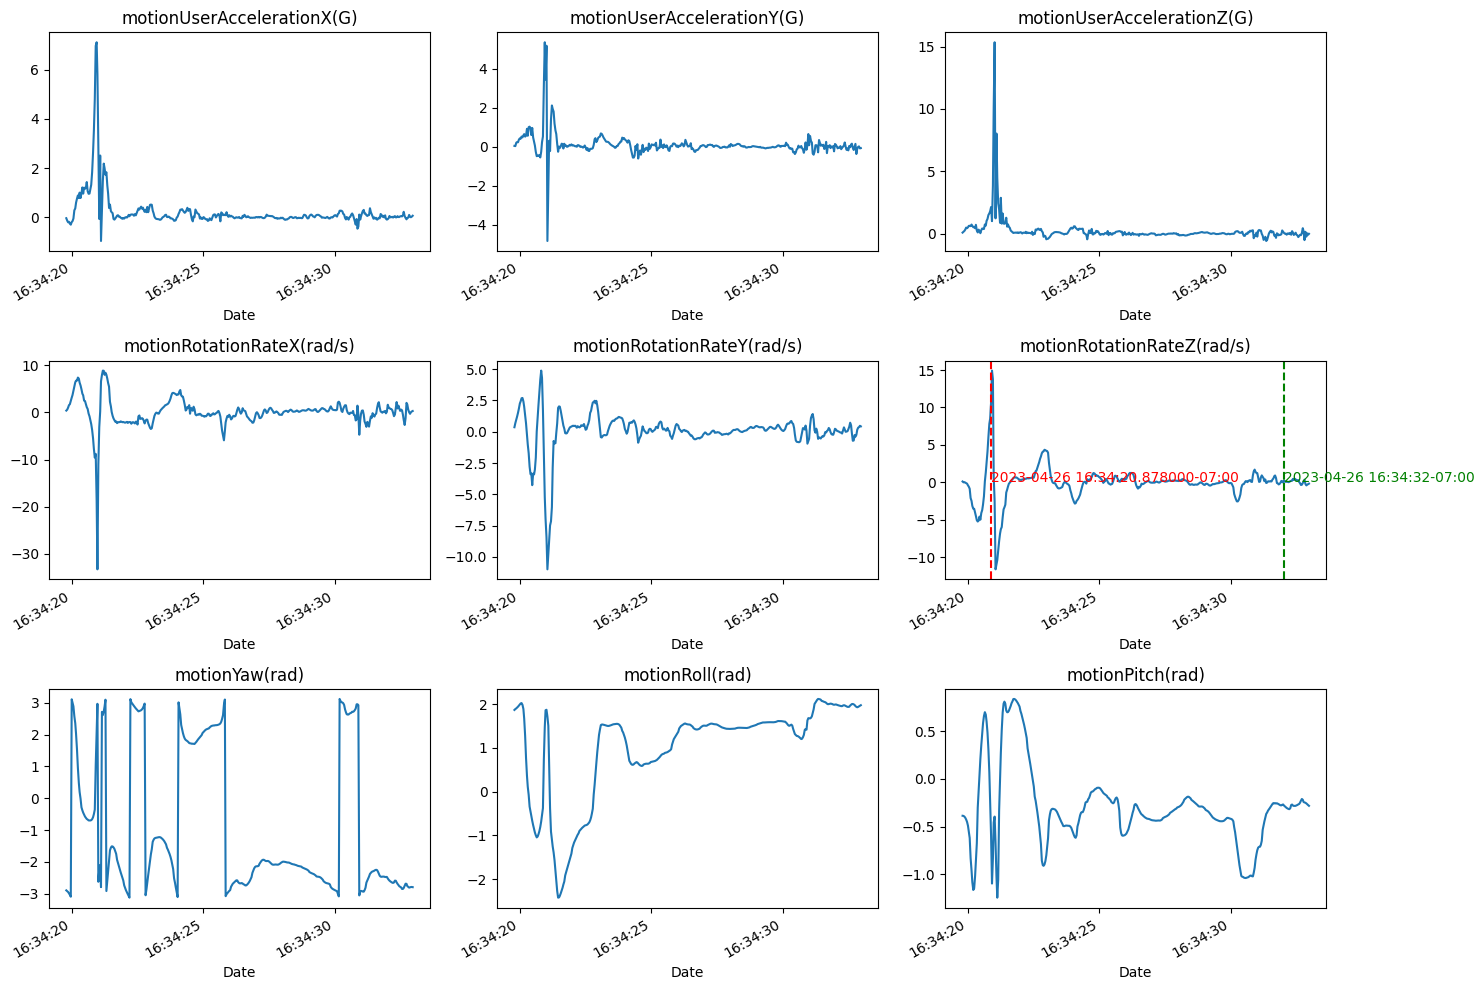

2023-05-11 13:34:25.818000-07:00
Total Distance: 164.48


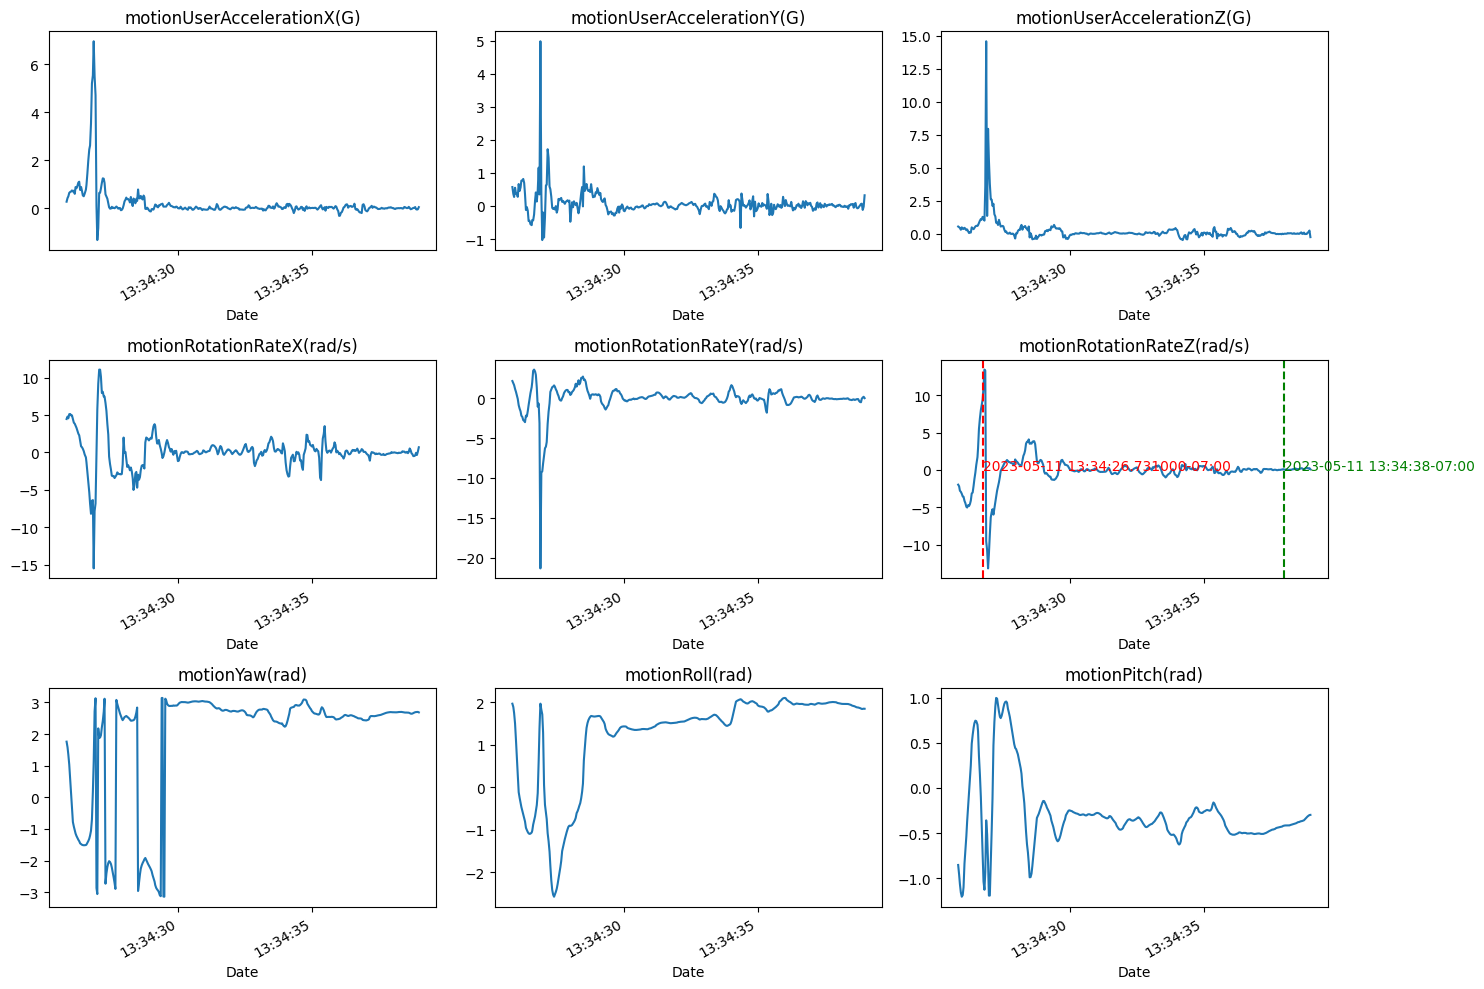

2023-05-11 13:36:31.826000-07:00
Total Distance: 156.26


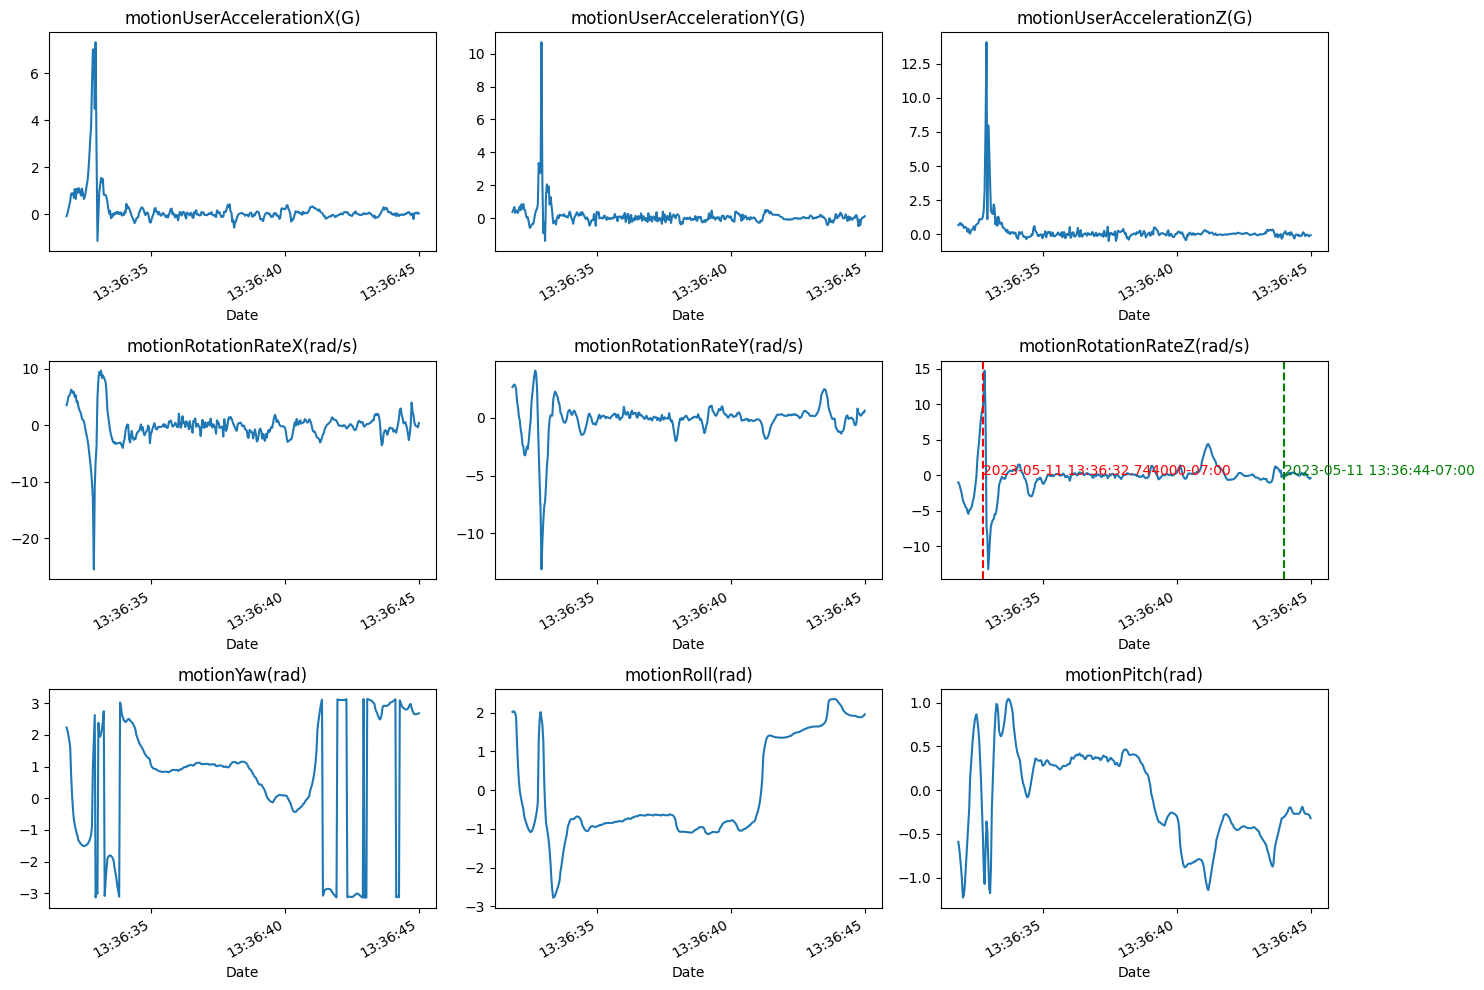

In [410]:
visualize_sample(mapped[3])
visualize_sample(mapped[4])
visualize_sample(mapped[5])
visualize_sample(mapped[20])
visualize_sample(mapped[50])
visualize_sample(mapped[-1])

2023-05-11 13:33:43.259000-07:00


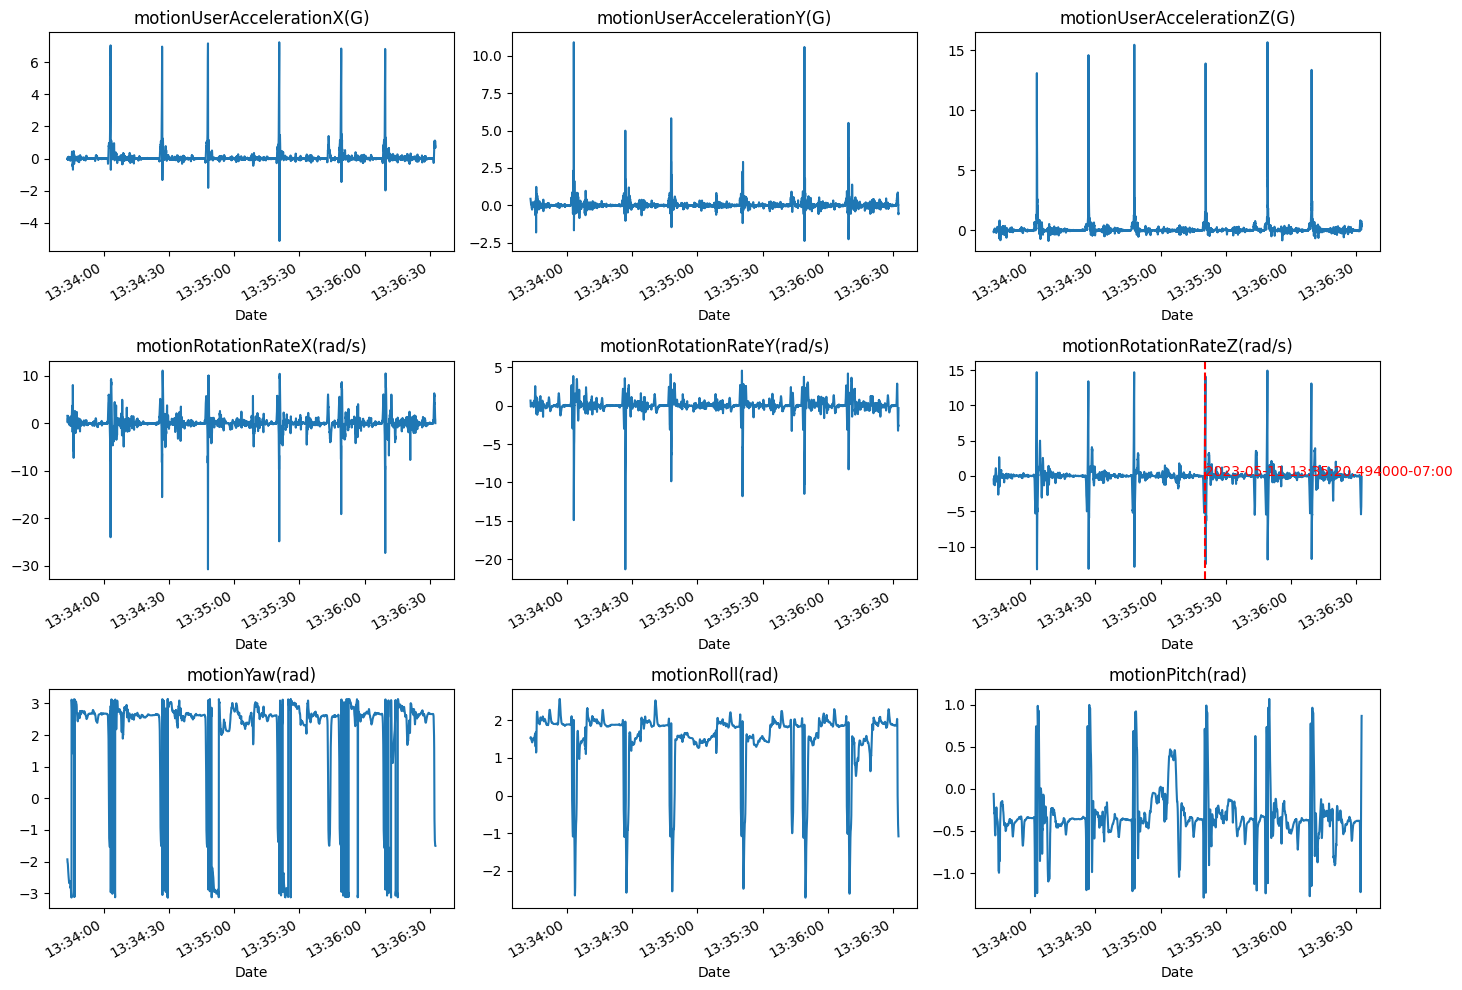

In [404]:
visualize_sample((None, applewatchdata[50000:55000]))

In [405]:
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
import plotly.graph_objects as go

def plot_motion_path(df):

    # Make a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    timestamps = pd.to_datetime(df['locationTimestamp_since1970(s)'], unit='s')
    time_diff = timestamps.diff()
    cumulative_seconds = time_diff.dt.total_seconds().cumsum().fillna(0)

    df_copy["Elapsed Time (s)"] = cumulative_seconds  
    time = df_copy['Elapsed Time (s)']

    df_copy['Acceleration X (m/s2)'] = df_copy['motionUserAccelerationX(G)'] * 9.80665
    df_copy['Acceleration Y (m/s2)'] = df_copy['motionUserAccelerationY(G)']* 9.80665
    df_copy['Acceleration Z (m/s2)'] = df_copy['motionUserAccelerationZ(G)']* 9.80665

    # Calculate velocity by integrating acceleration over time
    df_copy['Velocity X (m/s)'] = df_copy['Acceleration X (m/s2)'].cumsum() * df_copy['Elapsed Time (s)'].diff().fillna(0)
    df_copy['Velocity Y (m/s)'] = df_copy['Acceleration Y (m/s2)'].cumsum() * df_copy['Elapsed Time (s)'].diff().fillna(0)
    df_copy['Velocity Z (m/s)'] = df_copy['Acceleration Z (m/s2)'].cumsum() * df_copy['Elapsed Time (s)'].diff().fillna(0)

    # Calculate distance by integrating velocity over time
    df_copy['Distance X (m)'] = df_copy['Velocity X (m/s)'].cumsum() * df_copy['Elapsed Time (s)'].diff().fillna(0)
    df_copy['Distance Y (m)'] = df_copy['Velocity Y (m/s)'].cumsum() * df_copy['Elapsed Time (s)'].diff().fillna(0)
    df_copy['Distance Z (m)'] = df_copy['Velocity Z (m/s)'].cumsum() * df_copy['Elapsed Time (s)'].diff().fillna(0)

    x_dist = df_copy["Distance X (m)"]
    y_dist = df_copy["Distance Y (m)"]
    z_dist = df_copy["Distance Z (m)"]

    # Create a 3D plot
    fig = go.Figure(data=go.Scatter3d(
        x=x_dist,
        y=y_dist,
        z=z_dist,
        mode='markers',
        marker=dict(
            size=2,
            color=df['locationTimestamp_since1970(s)'],
            colorscale='Jet',
            colorbar=dict(thickness=20),
            opacity=0.8
        ),
        line=dict(color='darkblue', width=2)
    ))

    fig.show()


In [406]:
plot_motion_path(mapped[3][1])